In [1]:
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import data_preprocessing
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from tsfresh import extract_features


In [2]:
# Normalisierung der Daten
"""
Gerne mit periodLengthMS und sampling sampleRateUS rumspielen. Den Effekt von den Variablen könnt ihr in smartPunch_tutorial_ManipulatePeriodLength.ipynb sehen.  
"""
import json
import prepro

periodLengthMS = 1000
sampleRateUS = 10000


with open('lalulstolledaten.json', 'r') as f:
    dsds = json.load(f)





ds = prepro.jsonData_to_dataset_in_timedifference_us(dsds)

df_new = prepro.normate_dataset_period(periodLengthMS, sampleRateUS, ds)

Starting new normalization/interpolation...
progress: 0.34 %
progress: 0.68 %
progress: 1.01 %
progress: 1.35 %
progress: 1.69 %
progress: 2.03 %
progress: 2.36 %
progress: 2.70 %
progress: 3.04 %
progress: 3.38 %
progress: 3.72 %
progress: 4.05 %
progress: 4.39 %
progress: 4.73 %
progress: 5.07 %
progress: 5.41 %
progress: 5.74 %
progress: 6.08 %
progress: 6.42 %
progress: 6.76 %
progress: 7.09 %
progress: 7.43 %
progress: 7.77 %
progress: 8.11 %
progress: 8.45 %
progress: 8.78 %
progress: 9.12 %
progress: 9.46 %
progress: 9.80 %
progress: 10.14 %
progress: 10.47 %
progress: 10.81 %
progress: 11.15 %
progress: 11.49 %
progress: 11.82 %
progress: 12.16 %
progress: 12.50 %
progress: 12.84 %
progress: 13.18 %
progress: 13.51 %
progress: 13.85 %
progress: 14.19 %
progress: 14.53 %
progress: 14.86 %
progress: 15.20 %
progress: 15.54 %
progress: 15.88 %
progress: 16.22 %
progress: 16.55 %
progress: 16.89 %
progress: 17.23 %
progress: 17.57 %
progress: 17.91 %
progress: 18.24 %
progress: 18.

In [3]:
df = pd.DataFrame({'idx': range(len(df_new)), 'dfs': df_new})

In [4]:
gerade = []
kinnhaken = []
kopfhaken = []

#size_of_trainset = int(len(df) * 0.2)
#count_per_label = int(size_of_trainset / 3)


for i in range(len(df)):
    if(df.iloc[i][1].iloc[1].label == "Gerade"):
        kopfhaken.append(df.iloc[i][1])
    elif(df.iloc[i][1].iloc[1].label == "Kinnhaken"):
        kinnhaken.append(df.iloc[i][1])
    elif(df.iloc[i][1].iloc[1].label == "Kopfhaken"):
        gerade.append(df.iloc[i][1])


traindata = gerade+ kinnhaken+ kopfhaken

print(len(traindata))

296


In [5]:
x_train,y_train = [],[]

for df in traindata:
    y_train.append(df["label"].iloc[0])
    x_train.append(df.drop(columns=["timestamp", "label"]).values)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape, y_train.shape

((296, 101, 3), (296,))

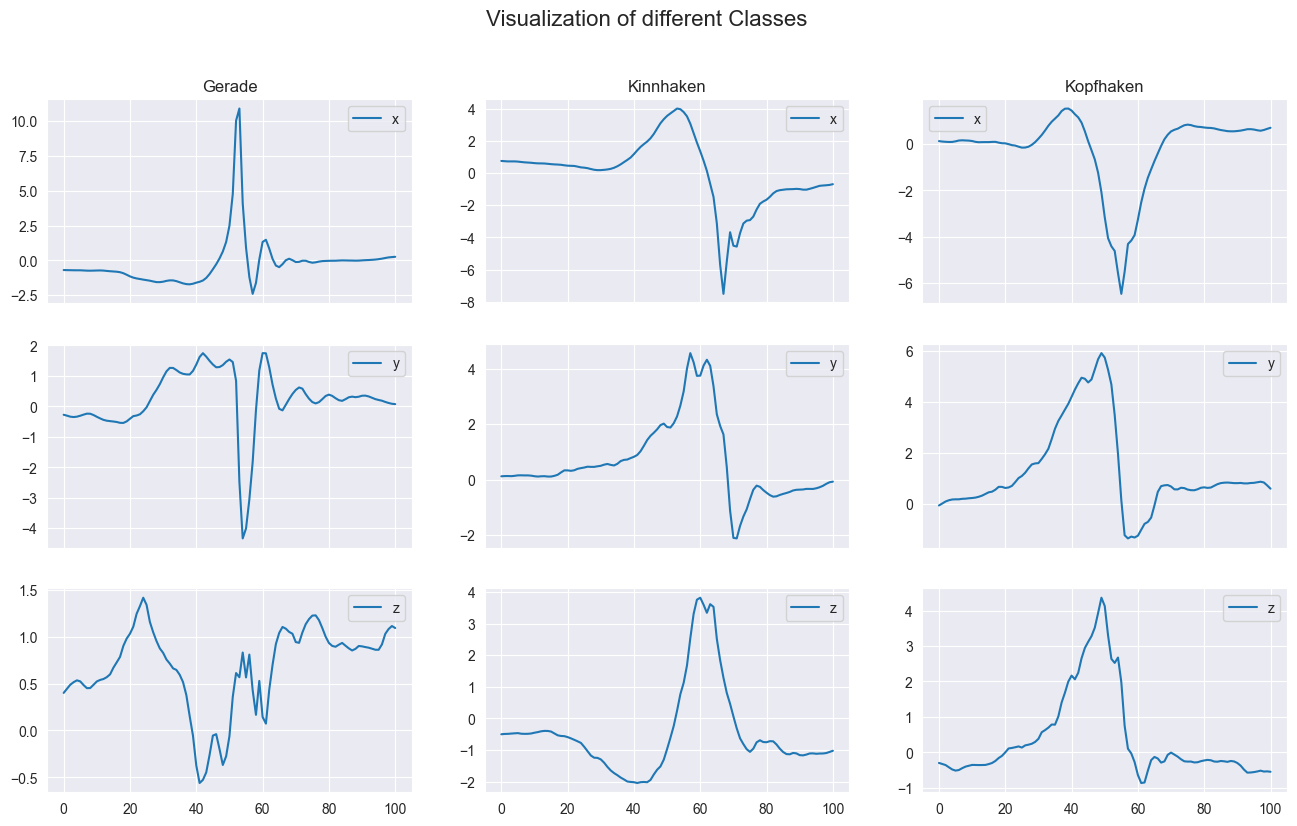

In [7]:
LABELS = ['Gerade', 'Kinnhaken', 'Kopfhaken']
# Set classes to visualize and set the feature names
FEATURE_NAMES = ['x', 'y', 'z']
CLASSES = ['Gerade', 'Kinnhaken', 'Kopfhaken']

fig, axs = plt.subplots(nrows=3, ncols=len(CLASSES), sharex=True, sharey=False)
fig.suptitle('Visualization of different Classes', fontsize=16)
fig.set_size_inches(16, 9)
x = np.arange(101)                                  #!!!!!! hier die dimensionen angeben 
for index, cls in enumerate(CLASSES):
    # Set class as label for top subplot of each column
    axs[0][index].set(title=cls)
    # Get random instance from training data with corresponding class
    instance_index = np.random.choice(np.argwhere(y_train == cls).flatten())
    instance = x_train[instance_index]
    # Plot the feature groups (all axis of one measurement) in the different subplots and add labels
    for sublot in [0, 1, 2]:
        axs[sublot][index].plot(x, instance[:, sublot])
        axs[sublot][index].legend(FEATURE_NAMES[sublot])
plt.show()

In [8]:
_label = ['Gerade', 'Kinnhaken', 'Kopfhaken']
category_to_num = {element: num for num, element in enumerate(_label)}
numerical_data = np.vectorize(category_to_num.get)(y_train)


y_train  = np.array(numerical_data)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

sk_X_train, sk_X_test, sk_y_train, sk_y_test = train_test_split(x_train, y_train, test_size=0.2)


In [15]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(shape=sk_X_train[0].shape),
        keras.layers.Conv2D(8, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(3, activation=keras.activations.softmax)
    ])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

ValueError: Input 0 of layer "conv2d_6" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 101, 3)

In [ ]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 50

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=10)
# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    callbacks=[stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

In [12]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(_label)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

NameError: name 'model' is not defined